## Imports

In [2]:
print('')

In [1]:
import os
import math
import obspy
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from datetime import timedelta
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

from earthquake import Earthquake
import util
import pandas as pd
from numba import jit
from multiprocessing import Pool

## Get set up
Set path to data, and read eq_list (all folders in root folder)

## the action!!
For all events with data, load their object . add tp_max and tc  to lists (for plotting)

In [2]:
list_tpmax = []
list_mags = []
list_mag_types = []
list_eq = []
eqs = {}
count = 0

In [3]:
parameters = [[1,0.1,19,0,'eq_object_1s_bandpass_01_19_snr_20_blank_0'],
[1,0.1,19,0.05,'eq_object_1s_bandpass_01_19_snr_20_blank_005'],
[1,0.1,19,0.1,'eq_object_1s_bandpass_01_19_snr_20_blank_01'],
[1,0.1,19,0.25,'eq_object_1s_bandpass_01_19_snr_20_blank_025'],
[1,0.1,19,0.5,'eq_object_1s_bandpass_01_19_snr_20_blank_05'],
[4,0.1,19,0,'eq_object_4s_bandpass_01_19_snr_20_blank_0'],
[4,0.1,19,0.05,'eq_object_4s_bandpass_01_19_snr_20_blank_005'],
[4,0.1,19,0.1,'eq_object_4s_bandpass_01_19_snr_20_blank_01'],
[4,0.1,19,0.25,'eq_object_4s_bandpass_01_19_snr_20_blank_025'],
[4,0.1,19,0.5,'eq_object_4s_bandpass_01_19_snr_20_blank_05']]
#[1,0.1,19,0.5,'eq_object_1s_bandpass_01_19_snr_20'],
#[2,0.1,19,0.5,'eq_object_2s_bandpass_01_19_snr_20'],
#[3,0.1,19,0.5,'eq_object_3s_bandpass_01_19_snr_20'],
#[4,0.1,19,0.5,'eq_object_4s_bandpass_01_19_snr_20']]


In [ ]:
def model_function(x_data, a, b):
    return 10**(a*x_data + b)

In [ ]:
def model_function_2(x_data, a, b):
    return a*x_data + b

In [ ]:
WINDOW_LENGTH=1

In [ ]:
def plot_for_params(list_mags, list_tpmax, title):
    %matplotlib inline
    params = []
    opacities = np.linspace(0.2,1,45)
    import matplotlib.pyplot as plt
    cs = ['midnightblue']#'#00a1c1']
    #fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
    y_aves_tp = []
    x_aves_tp = []
    count = 1
    eq_count = 0
    medians = [[] for _ in range(0, 45)]
    medians_of_medians = [[] for _ in range(0, 45)]
    n = 0
    median_absolute_deviation = []
    sum_absolute_deviation = []
    all_abs_deviation = []
    for n in [1]:#range(1, 10):#number of stations eq at least measured at
        med_for_ad = []
        mag_for_ad = []
        fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
        for mag_lim in [3.4]:#, 3.4, 4.0, 4.4]:#np.arange(3.0, 6.5, 0.1):
            print(time.perf_counter()) 
            y_aves_tp = []
            x_aves_tp = []
            for i  in range(0, len(list_mags)):

                if list_mags[i] > mag_lim and list_mags[i]<=max(list_mags):
                    if len(list_tpmax[i])>=n:
                        mean_tp = np.mean(list_tpmax[i]) 
                        std_tp = np.std(list_tpmax[i]) 
                        y_tp = [] 
                        for j in list_tpmax[i]: 
                            if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:# and j < 100: 
                                y_tp.append(math.log(j, 10))
                            elif len(list_tpmax[i])==1:
                                y_tp.append(math.log(j, 10))
                        x_tp = np.zeros(len(y_tp))  
                        x_tp = x_tp + list_mags[i]
                        c = 0
                        if len(x_tp)>0 and mag_lim == 3.4:
                            if math.isnan(np.median(y_tp))==False:
                                axs.scatter(list_mags[i]-5+np.random.uniform(-0.05, 0.05), np.median(y_tp), s = 50, c = cs[c], marker = '^', zorder =110, alpha = 0.5)
                            medians[int(np.round(x_tp[0],1)*10)-30].append(y_tp)
                            med_for_ad.append(np.median(y_tp))
                            mag_for_ad.append(list_mags[i])
                        if math.isnan(np.median(y_tp))==False:  
                            y_aves_tp.append(np.median(y_tp))
                            medians_of_medians[int(np.round(x_tp[0],1)*10)-30].append(np.median(y_tp))
                            x_aves_tp.append(list_mags[i])
            if len(y_aves_tp)>0:
                popt, pcov = curve_fit(model_function_2, x_aves_tp, y_aves_tp)
                params.append([popt, len(x_aves_tp)])
                print(mag_lim, popt)

                x_use = np.array(x_aves_tp) - 5
                y_use = np.array(y_aves_tp)

                if str(mag_lim) == str(3.4):
                    popt, pcov = curve_fit(model_function_2, x_use, y_use, absolute_sigma = True)
                    axs.plot(np.array(x_use), model_function_2(np.array(x_use), *popt), color='orange', zorder =100)
                    popt_final, pcov_final = popt, pcov

                print(len(x_aves_tp), len(y_aves_tp))
                count += 1
        try:
            med = []
            med_x = []
            med2 = []
            xs = np.arange(3,7.5,0.1)-5
            for i in range(0, len(medians_of_medians)):
                med.append(np.median(medians_of_medians[i]))
                if len(medians_of_medians[i])>0:
                    med_x.append(xs[i])
                    med2.append(np.median(medians_of_medians[i]))
            popt, pcov = popt_final, pcov_final
            perr = np.sqrt(np.diag(pcov))
            print(popt, perr)
            x_me = np.arange(0, 7.2, 0.1)
            x_lower_me = x_me - perr[1]*2
            x_upper_me =  x_me + perr[1]*2
            y_me = popt[0]*x_me+popt[1]
            y_lower_me = popt[0]*x_lower_me-popt[1]
            y_upper_me = popt[0]*x_upper_me-popt[1]

            a = popt[0]
            a_true = a
            b = popt[1]
            b_true = b
            std_a = perr[0]
            std_b = perr[1]
            x_me = np.arange(3, 7.2, 0.1)-5
            y_1 = (a+std_a)*x_me + (b+std_b)
            y_2 = (a+std_a)*x_me + (b-std_b)
            y_3 = (a-std_a)*x_me + (b+std_b)
            y_4 = (a-std_a)*x_me + (b-std_b)

            y_min = np.minimum(np.minimum(y_1, y_2), np.minimum(y_3, y_4))
            y_max = np.maximum(np.maximum(y_1, y_2), np.maximum(y_3, y_4))

            axs.set_xlabel("magnitude", fontsize = 14) 

            axs.set_ylabel("log(tp_max)", fontsize = 14) 
            axs.tick_params(axis='both', which='major', labelsize=14)
            axs.tick_params(axis='both', which='minor', labelsize=14)
            olsen_x = np.arange(3,7,0.1)
            olsen_y = 0.14*(olsen_x-5) - 0.83
            axs.plot(olsen_x-5, olsen_y)

            fig.suptitle(str(n)+ " --- window = "+str(WINDOW_LENGTH))

        except Exception:
            print('wrong')

        point_indices = np.array(mag_for_ad)*10-30
        absolute_deviation = []
        for ind in range(0, len(point_indices)):
            absolute_deviation.append(abs(10**med_for_ad[int(ind)]-(10**y_me[int(point_indices[ind])])))
        print(len(absolute_deviation))
        all_abs_deviation.append(absolute_deviation)
        sum_absolute_deviation.append(np.sum(absolute_deviation))
        median_absolute_deviation.append(np.median(absolute_deviation))
        x = x_me
        eigenvalues, eigenvectors = np.linalg.eig(pcov)
        theta = np.linspace(0, 2*np.pi, 1000);
        ev_95 = np.sqrt(5.99)*np.array([np.sqrt(eigenvalues[0]),np.sqrt(eigenvalues[1])])
        ellipsis_95 = (ev_95 * eigenvectors) @ [np.sin(theta), np.cos(theta)]
        for i in range(0, ellipsis_95.shape[1]):
            b_95 ,a_95 = ellipsis_95[:,i]
            axs.plot(x, (a_95+a_true)*x + (b_95+b_true), color = '#ffb253', alpha = 0.2, zorder = 100)
        for i in range(0, ellipsis_95.shape[1]):
            b_95 ,a_95 = ellipsis_95[:,i]
            axs.plot(x, (2*a_95+a_true)*x + (2*b_95+b_true), color = '#f7e6d6', alpha = 0.1, zorder = 100)
        axs.plot(x, popt[0]*x + popt[1], color = '#ff9500', zorder = 105, alpha = 1)
        axs.set_xticks([-2,-1,0,1,2,3], [3,4,5,6,7,8], zorder = 110)
        #plt.show()
        axs.set_ylim([-2,1])
        axs.set_title(title)
        plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/tp_different_params/'+title, format = 'pdf')

    #plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/tp_and_tc/different_station_numbers/1s_bandpass_n_stations_'+str(n)+'_plus_shading_based_on_34_plus.png')

In [8]:
def load_and_plot(p):
    fn = p[-1]
    list_tpmax = []
    list_mags = []
    folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/')
    #os_start = time.perf_counter()
    for eq_no in range(0, len(folders)):
        #start = time.perf_counter()
        if os.path.exists('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/'+folders[eq_no]+'/'+fn+'.pkl'):
            with open('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
                eq = pickle.load(picklefile)
            list_tpmax.append(eq.calculated_params['tau_p_max'])
            list_mags.append(eq.event_stats['eq_mag'])
            list_mag_types.append(eq.event_stats['eq_mag_type'])
            #stop = time.perf_counter()
    print(p[-1],'onto small')
    folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/')
    for eq_no in range(0, len(folders)):
        if os.path.exists('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl'):
            with open('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
                eq = pickle.load(picklefile)
            #print(time.perf_counter())
            list_tpmax.append(eq.calculated_params['tau_p_max'])
            list_mags.append(eq.event_stats['eq_mag'])
            list_mag_types.append(eq.event_stats['eq_mag_type'])
    #os_stop = time.perf_counter()
    #t_os.append(os_stop-os_start)
    print('loading')
    #print(p[-1])
    #plot_start = time.perf_counter()       
    plot_for_params(list_mags, list_tpmax, p[-1])
    #plot_stop = time.perf_counter()
    #t_plot.append(plot_stop-plot_start)
    #print(p[-1],plot_stop-plot_start)

In [ ]:
with Pool(os.cpu_count()//2) as pool:
    pool.map(load_and_plot, parameters)

eq_object_4s_bandpass_01_19_snr_20_blank_0 onto small
eq_object_4s_bandpass_01_19_snr_20_blank_005 onto small
eq_object_1s_bandpass_01_19_snr_20_blank_05 onto small
eq_object_4s_bandpass_01_19_snr_20_blank_01 onto small
eq_object_1s_bandpass_01_19_snr_20_blank_01 onto small
eq_object_1s_bandpass_01_19_snr_20_blank_005eq_object_1s_bandpass_01_19_snr_20_blank_025  onto smallonto small

eq_object_1s_bandpass_01_19_snr_20_blank_0 onto small


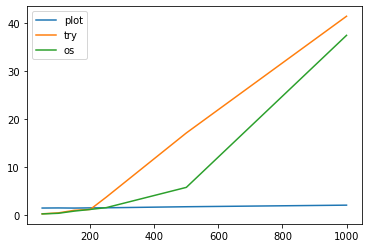

In [39]:
plt.plot(n_list, t_plot, label = 'plot')
plt.plot(n_list, t_try, label = 'try')
plt.plot(n_list, t_os, label = 'os')
plt.legend()

In [57]:
popt

array([ 0.22078975, -0.42960692])

In [58]:
pcov

array([[0.00681407, 0.00680199],
       [0.00680199, 0.00873924]])

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(pcov)

In [ ]:
eigenvalues

In [ ]:
eigenvalues[0]

In [ ]:
theta = np.linspace(0, 2*np.pi, 1000);
ellipsis = (np.sqrt(eigenvalues[None,:]) * eigenvectors) @ [np.sin(theta), np.cos(theta)]
plt.plot(popt[0]+ellipsis[0,:], popt[1]+ellipsis[1,:])

In [ ]:
len(x_use)

In [ ]:
[np.sqrt(eigenvalues[0]/len(x_use)-1),np.sqrt(eigenvalues[1]/len(x_use)-1)]

In [ ]:
theta = np.linspace(0, 2*np.pi, 1000);
ev_95 = np.sqrt(5.99)*np.array([np.sqrt(eigenvalues[0]/(len(y_tp)-1)),np.sqrt(eigenvalues[1]/(len(y_tp)-1))])
ellipsis_95 = (ev_95 * eigenvectors) @ [np.sin(theta), np.cos(theta)]
plt.plot(ellipsis_95[0,:], ellipsis_95[1,:])

In [ ]:
ev_95

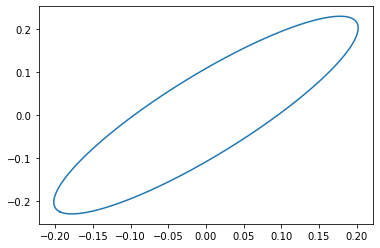

In [59]:
plt.plot(ellipsis_95[0,:], ellipsis_95[1,:])

In [ ]:
popt

##### popt

In [ ]:
eigenvalues[0]/(len(x_use)-1)

In [ ]:
ellipsis_95

In [ ]:
[1/np.sqrt(eigenvalues[0]),1/np.sqrt(eigenvalues[1])]*2.44

In [ ]:
popt[0]*x + popt[1]

In [ ]:
x = np.arange(3,7,0.1)

In [ ]:
for i in range(0, ellipsis.shape[1]):
    b,a = ellipsis[:,i]
    plt.plot(x, a*x + b, color = 'k')
plt.plot(x, popt[0]*x + popt[1], color = 'orange')
axs.scatter(list_mags[i]-5+np.random.uniform(-0.05, 0.05), np.median(y_tp), s = 50, c = cs[c], marker = '^', zorder =4, alpha = 0.7)

In [ ]:
for i in range(0, ellipsis.shape[1]):
    b,a = ellipsis_95[:,i]
    plt.plot(x, a*x + b, color = 'k')
plt.plot(x, popt[0]*x + popt[1], color = 'orange')

In [ ]:
a

In [ ]:
x_use = []
x_use.append(x_aves_tp)
x_use.append(x_aves_tp)
x_use.append(x_aves_tp)
x_use = np.concatenate(x_use )

In [ ]:
x_use

In [ ]:
np.array(x_aves_tp[-1]).shape

In [ ]:
    point_indices = np.array(mag_for_ad)*10-30
    absolute_deviation = []
    for ind in range(0, len(point_indices)):
        absolute_deviation.append((med_for_ad[int(ind)]-y_me[int(point_indices[ind])]))
    print(max(absolute_deviation))
    #all_abs_deviation.append(absolute_deviation)
    #median_absolute_deviation.append(np.median(absolute_deviation))

In [ ]:
plt.scatter(mag_for_ad, med_for_ad)
plt.scatter(np.arange(0,7.2,0.1), y_me)
plt.scatter(mag_for_ad, absolute_deviation)

In [ ]:
len(np.arange(0,7,0.1))

In [ ]:
max(absolute_deviation)

In [ ]:
median_absolute_deviation

In [ ]:
fig, ax1 = plt.subplots(1,1)
ax1.scatter(range(1,10), median_absolute_deviation)
ax1.set_ylabel('median absolute deviation', color = 'blue')
ax2 = ax1.twinx()
ax2.scatter(range(1,10), sum_absolute_deviation, color = 'orange')
ax2.set_ylabel('sum absolute deviation', color = 'orange')
ax1.set_xlabel('recorded at more than x stations')
plt.title('distances NOT in log space')

In [ ]:
len(median_absolute_deviation)

In [ ]:
b

In [ ]:
std_b

In [ ]:
y_1

In [ ]:
y_2

In [ ]:
y_3

In [ ]:
y_4

In [ ]:
y_min

In [ ]:
y_max

In [ ]:
y_me

In [ ]:
len(list_tpmax)

In [ ]:
model_function_2(np.array(med_x), *popt)

In [ ]:
popt

In [ ]:
for i in range(0, len(medians_of_medians)):
    print(np.median(medians_of_medians[i]))

In [ ]:
plt.scatter(np.arange(3,7.5,0.1), np.median(medians_of_medians))

In [ ]:
popt

In [ ]:
pcov

In [ ]:
gradt = []
intercept = []
for i in params:
    gradt.append(i[0])
    intercept.append(i[1])

In [ ]:
bins

In [ ]:
plt.plot(n)

In [ ]:
%matplotlib qt
# create figure and axis objects with subplots()
fig,axs = plt.subplots(4,1, figsize = (15,9), sharex = True)
ax = axs[0]
ax4 = axs[1]
ax2 = axs[2]
ax3 = axs[3]
# make a plot
n, bins = np.histogram(list_mags, bins=np.arange(3,7.5,0.1))
ax.plot(bins[:-1]+0.05, n, color="red", marker="o")
n, bins = np.histogram(list_mags, bins=np.arange(3,7.5,0.1))
for i in range(1, len(n)):
    n[i] = n[i]+n[i-1]
#ax4 = ax.twinx()
ax4.plot(bins[:-1]+0.05, n, color="red", marker="o")
# set x-axis label
#ax.set_xlabel("year",fontsize=14)
# set y-axis label
#ax.set_ylabel("lifeExp",color="red",fontsize=14)
# twin object for two different y-axis on the sample plot
#ax2=ax.twinx()
#ax3=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(np.arange(3,6.6,0.1),intercept, color="blue",marker="o")
ax2.hlines(-0.83, 3, 7.5, color='blue')
ax3.plot(np.arange(3,6.6,0.1),gradt, color="green",marker="o")
ax2.set_ylabel("gdpPercap",color="blue",fontsize=14)
ax3.hlines(0.14, 3, 7.5, color='green')

ax.set_yscale('log')
ax4.set_yscale('log')
axs[0].grid(axis = 'both', which='major', linestyle='-', color='darkgrey')
axs[0].grid(axis = 'x', which='minor', linestyle=':')
axs[1].grid(axis = 'both', which='major', linestyle='-', color='darkgrey')
axs[1].grid(axis = 'x', which='minor', linestyle=':')
axs[2].grid(axis = 'both', which='major', linestyle='-', color='darkgrey')
axs[2].grid(axis = 'x',which='minor', linestyle=':')
axs[3].grid(axis = 'both', which='major', linestyle='-', color='darkgrey')
axs[3].grid(axis = 'x', which='minor', linestyle=':')
ax.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
ax4.minorticks_on()

ax.set_ylabel("log(N)",color="red",fontsize=14)
ax4.set_ylabel("log(cumulative N)",color="red",fontsize=14)
ax2.set_ylabel("intercept",color="blue",fontsize=14)
ax3.set_ylabel("gradient",color="green",fontsize=14)
ax3.set_xlabel('magnitude')
#ax3.set_xlim([3,5])
plt.show()

In [ ]:
plt.axvline()

In [ ]:
plt.hist(list_mags, bins = np.arange(3,7.5,0.1))
plt.yscale('log')
plt.ylabel('log(N)')
plt.xlabel('magnitude')

In [ ]:
x_tp

In [ ]:
y

In [ ]:
min(y_tp)

In [ ]:
x_tp

In [ ]:
plt.figure(figsize=(20,10))
y_limits = np.linspace(min(y_tp), max(y_tp), 40)
x_limits = np.linspace(3, 7, 41)
H, xedges, yedges = np.histogram2d(list(x_tp), list(y_tp), bins=[x_limits, y_limits])
H = H.T

plt.imshow(np.log(H), interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], (yedges[0]), (yedges[-1])], aspect = 0.5, cmap = 'inferno', vmin = np.log10(0.5))
plt.colorbar(label = 'log10(histogram amplitude)')

plt.ylabel('log10(tp_max)')
plt.xlabel('magntitude')
plt.ylim([-1,3])

#initial_guess = (1.4,0)
#res = optimize.minimize(obj, initial_guess, method = 'Nelder-mead')
#x = np.linspace(min(mag_plot), max(mag_plot), 20)
#y = res.x[0] * x + res.x[1]
#plt.plot(x,y, label = str(res.x[0]) + '*x+'+ str(res.x[1]))
#plt.scatter(np.arange(3, 6.8, 0.1), np.log10(mag_bin_medians), marker = 'x', color = 'silver')


plt.scatter(med_x, med2, marker = '^', color='silver', zorder = 1000)

popt, pcov = curve_fit(model_function_2, np.array(med_x[4:20]), np.array(med2[4:20]))
plt.plot(med_x[4:20], model_function_2(np.array(med_x[4:20]), *popt), color='yellow', linestyle = '-.')
popt, pcov = curve_fit(model_function_2, np.array(med_x[20:28]), np.array(med2[20:28]))
plt.plot(med_x[20:28], model_function_2(np.array(med_x[20:28]), *popt), color='yellow', linestyle = '-.')
popt, pcov = curve_fit(model_function_2, np.array(med_x[20:]), np.array(med2[20:]))
plt.plot(med_x[20:], model_function_2(np.array(med_x[20:]), *popt), color='yellow', linestyle = '-.')
popt, pcov = curve_fit(model_function_2, np.array(med_x), np.array(med2))
plt.plot(med_x, model_function_2(np.array(med_x), *popt), color='yellow')

plt.show()

In [ ]:
popt

In [ ]:
x_tp = []
y_tp = []
for i  in range(0, len(list_mags)):
    mag_lim = 3.4
    count = 0
    if list_mags[i] > mag_lim and list_mags[i]<=max(list_mags):
        mean_tp = np.mean(list_tpmax[i]) 
        std_tp = np.std(list_tpmax[i]) 
        for j in list_tpmax[i]: 
            if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:# and j < 100: 
                y_tp.append(math.log(j, 10))
                count += 1
            elif len(list_tpmax[i])==1:
                y_tp.append(math.log(j, 10))
                count += 1

        x_mag = np.zeros(count)  
        x_mag = x_mag + list_mags[i]
        x_tp = np.concatenate((np.array(x_tp), np.array(x_mag)))


In [ ]:
x_mag

find location of tpmax in time

In [ ]:
client = Client("IRIS")
# cat = client.get_events(starttime=UTCDateTime("2019-01-01"), endtime=UTCDateTime("2020-01-01"), minmagnitude=5, includearrivals=True)
cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3_catalog.xml')

In [ ]:
eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files') and os.path.exists(root+eq_name+'/picks.pkl'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])
print(len(eq_with_data))

In [ ]:
eq.data[0].stats['sampling_rate']

In [ ]:
eq.data

In [ ]:
eq.data_stats['picks']

In [ ]:
eq.data[0].stats

In [ ]:
eq.data[0].stats.network+'.'+eq.data[0].stats.station+'.'+eq.data[0].stats.location

In [ ]:
eq.data

In [ ]:
%matplotlib qt 
WINDOW_LENGTH = 4
diff = []
for eq_no in range(0, len(eq_with_data)):
    print(eq_no)
    #try:
    with open('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+eq_with_data[eq_no]+'/eq_object.pkl', 'rb') as picklefile:
        eq = pickle.load(picklefile)
        keys = list(eq.data_stats['picks'].keys())
        #print(eq.data)
        for i in range(len(eq.calculated_params['tau_p_max'])):
            
            name = eq.data[i*3+2].stats.network+'.'+eq.data[i*3+2].stats.station+'.'+eq.data[i*3+2].stats.location
            if name in eq.data_stats['picks'].keys():
                #print(eq.data[i*3].stats.network+'.'+eq.data[i*3].stats.station+'.'+eq.data[i*3].stats.location)
                #eq.data[i*3].plot()
                pick = (eq.data_stats['picks'][name]-eq.data[i*3+2].stats.starttime)*eq.data[i*3+2].stats.sampling_rate
                #plt.plot(eq.calculated_params['tau_p'][i])
                #plt.axhline(eq.calculated_params['tau_p_max'][i], 0, 1000)
                #plt.show()
                pick_seconds = pick / (eq.data[i*3].stats['sampling_rate'])
                a = np.where(eq.calculated_params['tau_p'][i][int(pick):]==eq.calculated_params['tau_p_max'][i])
                if len(a[0])>0:
                    max_loc = a[0][0]* 100/(eq.data[i*3+2].stats['sampling_rate'])+pick * 100/(eq.data[i*3+2].stats['sampling_rate'])
                    #print(eq.data[i*3])
                    if abs(max_loc-pick* 100/(eq.data[i*3+2].stats['sampling_rate'])) < 4 * eq.data[i*3].stats['sampling_rate']:
                        #eq.data[i*3+2].plot()
                        #plt.plot(eq.calculated_params['tau_p'][i][int(pick):])
                        #plt.axhline(eq.calculated_params['tau_p_max'][i], 0, 1000)
                        #plt.show()
                        #print(i)
                        #print(eq.calculated_params['tau_p_max'][i])
                        #print(max(eq.calculated_params['tau_p'][i][int(pick)+50:int(pick)+400]))
                        #print(eq.data[i*3+2].stats.sampling_rate)
                        #print(pick)
                        #print(max_loc)
                        #print(max_loc-pick* 100/(eq.data[i*3].stats['sampling_rate']))
                        diff.append((max_loc-pick*100/(eq.data[i*3].stats['sampling_rate']))/100)
    #list_tpmax.append(eq.calculated_params['tau_p_max'])

    #except Exception:
    #    print('in except')
    #    continue

In [ ]:
a[0][0]

In [ ]:
eq.calculated_params['tau_p_max'][i]

In [ ]:
max(diff)

In [ ]:
plt.hist(diff, np.arange(0, 4, 0.1))
plt.ylabel('time from pick')
plt.xlabel('n')
plt.title('timing of tpmax')

In [ ]:
a

In [ ]:
eq.calculated_params['tau_p'][i][int(pick):]

In [ ]:
eq.calculated_params['tau_p_max'][i]